In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

Setting environment for Gordon


In [2]:
stack_fixed = 'MD590'

In [3]:
train_sample_scheme = 1
global_transform_scheme = 1

local_transform_scheme = 1
# 1: no regularization
# 2: with regularization
# 3: no regularization, with surround
# 4: with regularization, with surround

if local_transform_scheme == 1:
    reg_weights = np.array([0.,0.,0.])
elif local_transform_scheme == 2:
    reg_weights = np.array([1e-4, 1e-4, 1e-4])
elif local_transform_scheme == 3:
    reg_weights = np.array([0.,0.,0.])
elif local_transform_scheme == 4:
    reg_weights = np.array([1e-4, 1e-4, 1e-4])
    
stack_moving = 'atlas_on_MD589'

In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [5]:
label_to_name_fixed = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_fixed = {n:l for l, n in label_to_name_fixed.iteritems()}

In [6]:
structures_sided = sum([[n] if n in singular_structures 
                        else [convert_to_left_name(n), convert_to_right_name(n)] 
                        for n in structures], [])

In [7]:
if local_transform_scheme == 1 or local_transform_scheme == 2:
    
    label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided)}
    name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

elif local_transform_scheme == 3 or local_transform_scheme == 4:

    structures_sided_plus_surround = sum([[s, s+'_surround'] for s in structures_sided], [])

    label_to_name_moving = {i+1: name for i, name in enumerate(structures_sided_plus_surround)}
    name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

In [8]:
def convert_to_original_name(name):
    return name.split('_')[0]

labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[convert_to_original_name(name_m)]

In [9]:
label_weights_m = {}
for label_m, name_m in label_to_name_moving.iteritems():
    if 'surround' in name_m:
        if local_transform_scheme == 1 or local_transform_scheme == 2:
            label_weights_m[label_m] = 0
        elif local_transform_scheme == 3 or local_transform_scheme == 4:
            label_weights_m[label_m] = -1
    else:
        label_weights_m[label_m] = 1

In [10]:
volume_fixed = {name_to_label_fixed[name]: DataManager.load_score_volume(stack=stack_fixed, label=name, downscale=32, train_sample_scheme=train_sample_scheme)
               for name in structures}

print volume_fixed.values()[0].shape
print volume_fixed.values()[0].dtype

vol_fixed_xmin, vol_fixed_ymin, vol_fixed_zmin = (0,0,0)
vol_fixed_ymax, vol_fixed_xmax, vol_fixed_zmax = np.array(volume_fixed.values()[0].shape) - 1
vol_fixed_xdim = vol_fixed_xmax + 1 - vol_fixed_xmin
vol_fixed_ydim = vol_fixed_ymax + 1 - vol_fixed_ymin
vol_fixed_zdim = vol_fixed_zmax + 1 - vol_fixed_zmin

(408, 548, 358)
float16


In [11]:
if local_transform_scheme == 1 or local_transform_scheme == 2:

    volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
                                                                                       type_m='score',
                                                                                       stack_f=stack_fixed,
                                                                                       type_f='score',
                                                                                       downscale=32,
                                                                                       train_sample_scheme_f=train_sample_scheme,
                                                                                       label=name_s)
                     for name_s in structures_sided}

elif local_transform_scheme == 3 or local_transform_scheme == 4:
    
    volume_moving = {name_to_label_moving[name_s]: DataManager.load_transformed_volume(stack_m='atlas_on_MD589',
                                                                                       type_m='score',
                                                                                       stack_f=stack_fixed,
                                                                                       type_f='score',
                                                                                       downscale=32,
                                                                                       train_sample_scheme_f=train_sample_scheme,
                                                                                       label=name_s)
                     for name_s in structures_sided_plus_surround}
    

print volume_moving.values()[0].shape
print volume_moving.values()[0].dtype

vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = np.array(volume_moving.values()[0].shape) - 1

(408, 548, 358)
float16


In [12]:
import numdifftools as nd
# https://media.readthedocs.org/pdf/numdifftools/latest/numdifftools.pdf

In [235]:
# for name_s in structures_sided:
for name_s in ['10N_L']:
    
    print name_s

    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)
        
    ###########################################
    
#     def perturb(tx, ty, tz):
#         return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz])

#     Hs = []
#     step_sizes = np.linspace(1, 20, 11)

#     for step_size in step_sizes:
#         h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(step_size, step_size, step_size))
#         H = h((0,0,0))
#         Hs.append(H)

#     ############################################################
    
#     fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)

#     create_if_not_exists(os.path.dirname(fp))
#     save_pickle(dict(zip(step_sizes, Hs)), fp)
    
    ############################################################

    fmax = aligner.compute_score(tx_params)

    zscores = []
#     pooling_radius_list = np.linspace(5, 100, 10)
    pooling_radius_list = np.arange(5, 100, 5)

    for pooling_radius in pooling_radius_list:

#         print pooling_radius

#         n_grid = 40
#         neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
#                                                                    dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
#                                                                     dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
#                                                                     dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))

        grid_size = 3
        neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                                   dxs=np.arange(-pooling_radius, pooling_radius, grid_size),
                                                                    dys=np.arange(-pooling_radius, pooling_radius, grid_size),
                                                                    dzs=np.arange(-pooling_radius, pooling_radius, grid_size))
        m = np.mean(neighbor_scores)
        z = (fmax - m) / np.std(neighbor_scores)

        zscores.append(z)

#     plt.plot(pooling_radius_list, zscores);
#     plt.xlabel('pooling radius (pixels)');
#     # plt.xticks(range(len(pooling_radius_list)), map(lambda x: '%.2f' % x, pooling_radius_list));
#     plt.ylabel('z-score');
#     plt.title('Z-score for different pooling radius');
#     plt.show();
    
#     zscores_allStructures[name_s] = zscores
    
    ##################################################################

    fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                    moving_volume_type='score', fixed_volume_type='score', 
                                    label=name_s,
                                    train_sample_scheme=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme)
    
    create_if_not_exists(os.path.dirname(fp))
    save_pickle(dict(zip(pooling_radius_list, zscores)), fp)


10N_L


In [239]:
np.arange(-pooling_radius, pooling_radius, grid_size).shape

(64,)

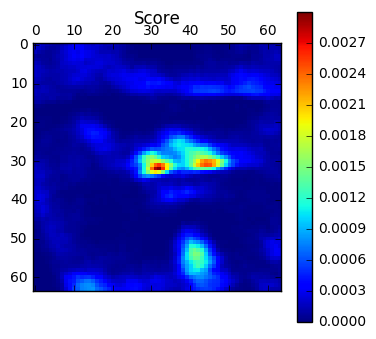

In [251]:
plt.matshow(np.reshape(neighbor_scores, (64,64,64))[32, :, :]);
plt.colorbar();
plt.title('Score');

In [219]:
fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
hessians = load_pickle(fp)

In [248]:
H = hessians[20.0]
U, S, UT = np.linalg.svd(H)
d = np.sqrt(2*(fmax-m)/S[0])
print d

36.342158512


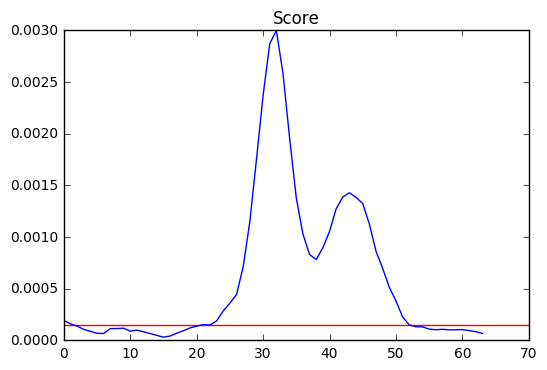

In [253]:
plt.plot(np.reshape(neighbor_scores, (64,64,64))[32, 32, :]);
plt.hlines(np.mean(neighbor_scores), 0, 70, colors='r');
plt.title('Score');

In [131]:
# delta_R = affine_components_to_vector(tx=0, ty=0, tz=0, theta_xy=np.deg2rad(45)).reshape((3,4))[:3,:3]
# curr_R = tx_params.reshape((3,4))[:3,:3]
# curr_t = tx_params.reshape((3,4))[:3, 3]
# new_R = np.dot(curr_R, delta_R)
# new_tx_params = np.ravel(np.c_[new_R, curr_t])

In [18]:
zscores_allStructures = {}

for name_s in structures_sided:
    
    fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                    moving_volume_type='score', fixed_volume_type='score', 
                                    label=name_s,
                                    train_sample_scheme=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme)

    zscores = load_pickle(fp)
    
    zscores_allStructures[name_s] = zscores

In [137]:
D = np.array([[z for r, z in d.items()] for n, d in sorted(zscores_allStructures.items())])

In [20]:
boxplot_labels = sorted(zscores_allStructures.keys())

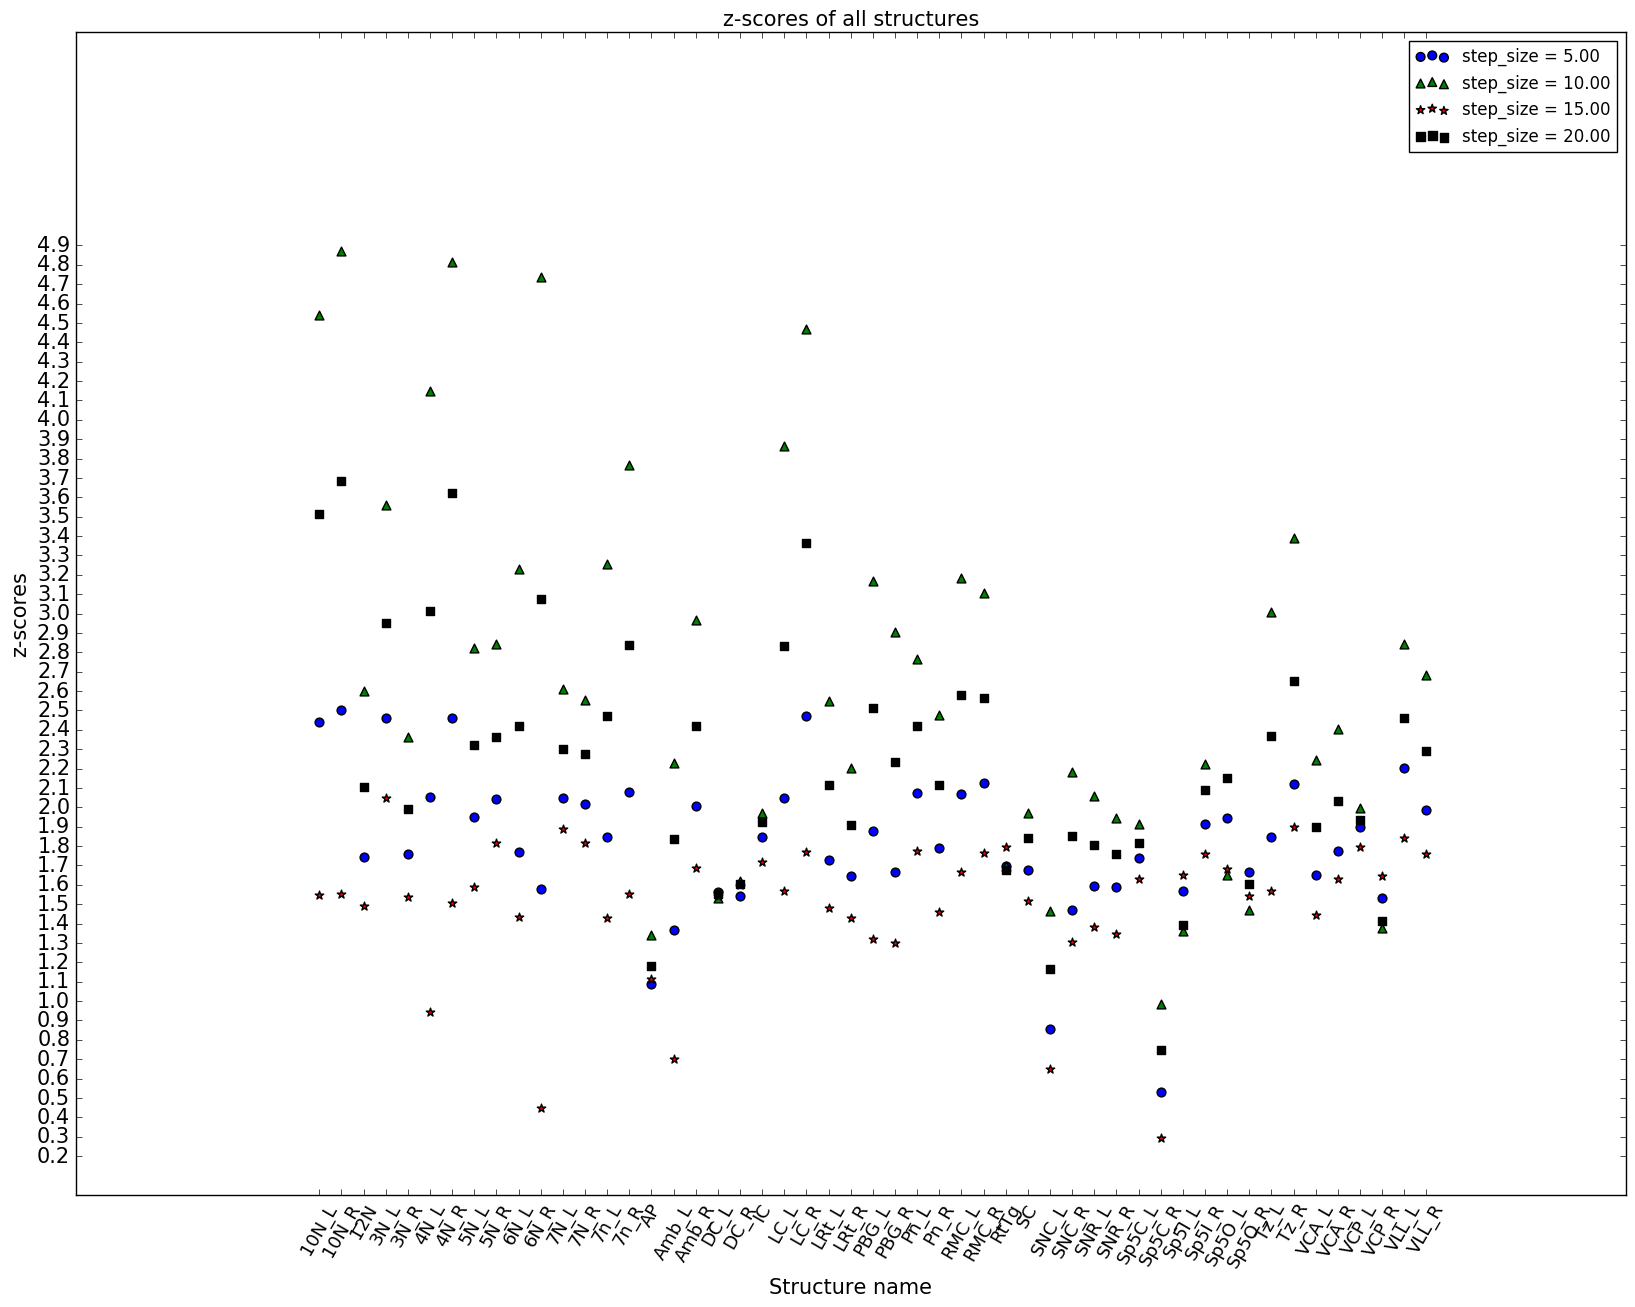

In [172]:
fig = plt.figure(figsize=(20, 15));
# fig, axes = plt.subplots(4, 1, figsize=(20, 30), sharex=False, sharey=True);

plt.scatter(range(1, len(boxplot_labels)+1), D[:,0], marker='o', s=40, c='b', label='step_size = %.2f' % pooling_radius_list[0]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,1], marker='^', s=40, c='g', label='step_size = %.2f' % pooling_radius_list[1]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,2], marker='*', s=40, c='r', label='step_size = %.2f' % pooling_radius_list[2]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,3], marker='s', s=40, c='k', label='step_size = %.2f' % pooling_radius_list[3]);

plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures', fontsize=15);
plt.legend();

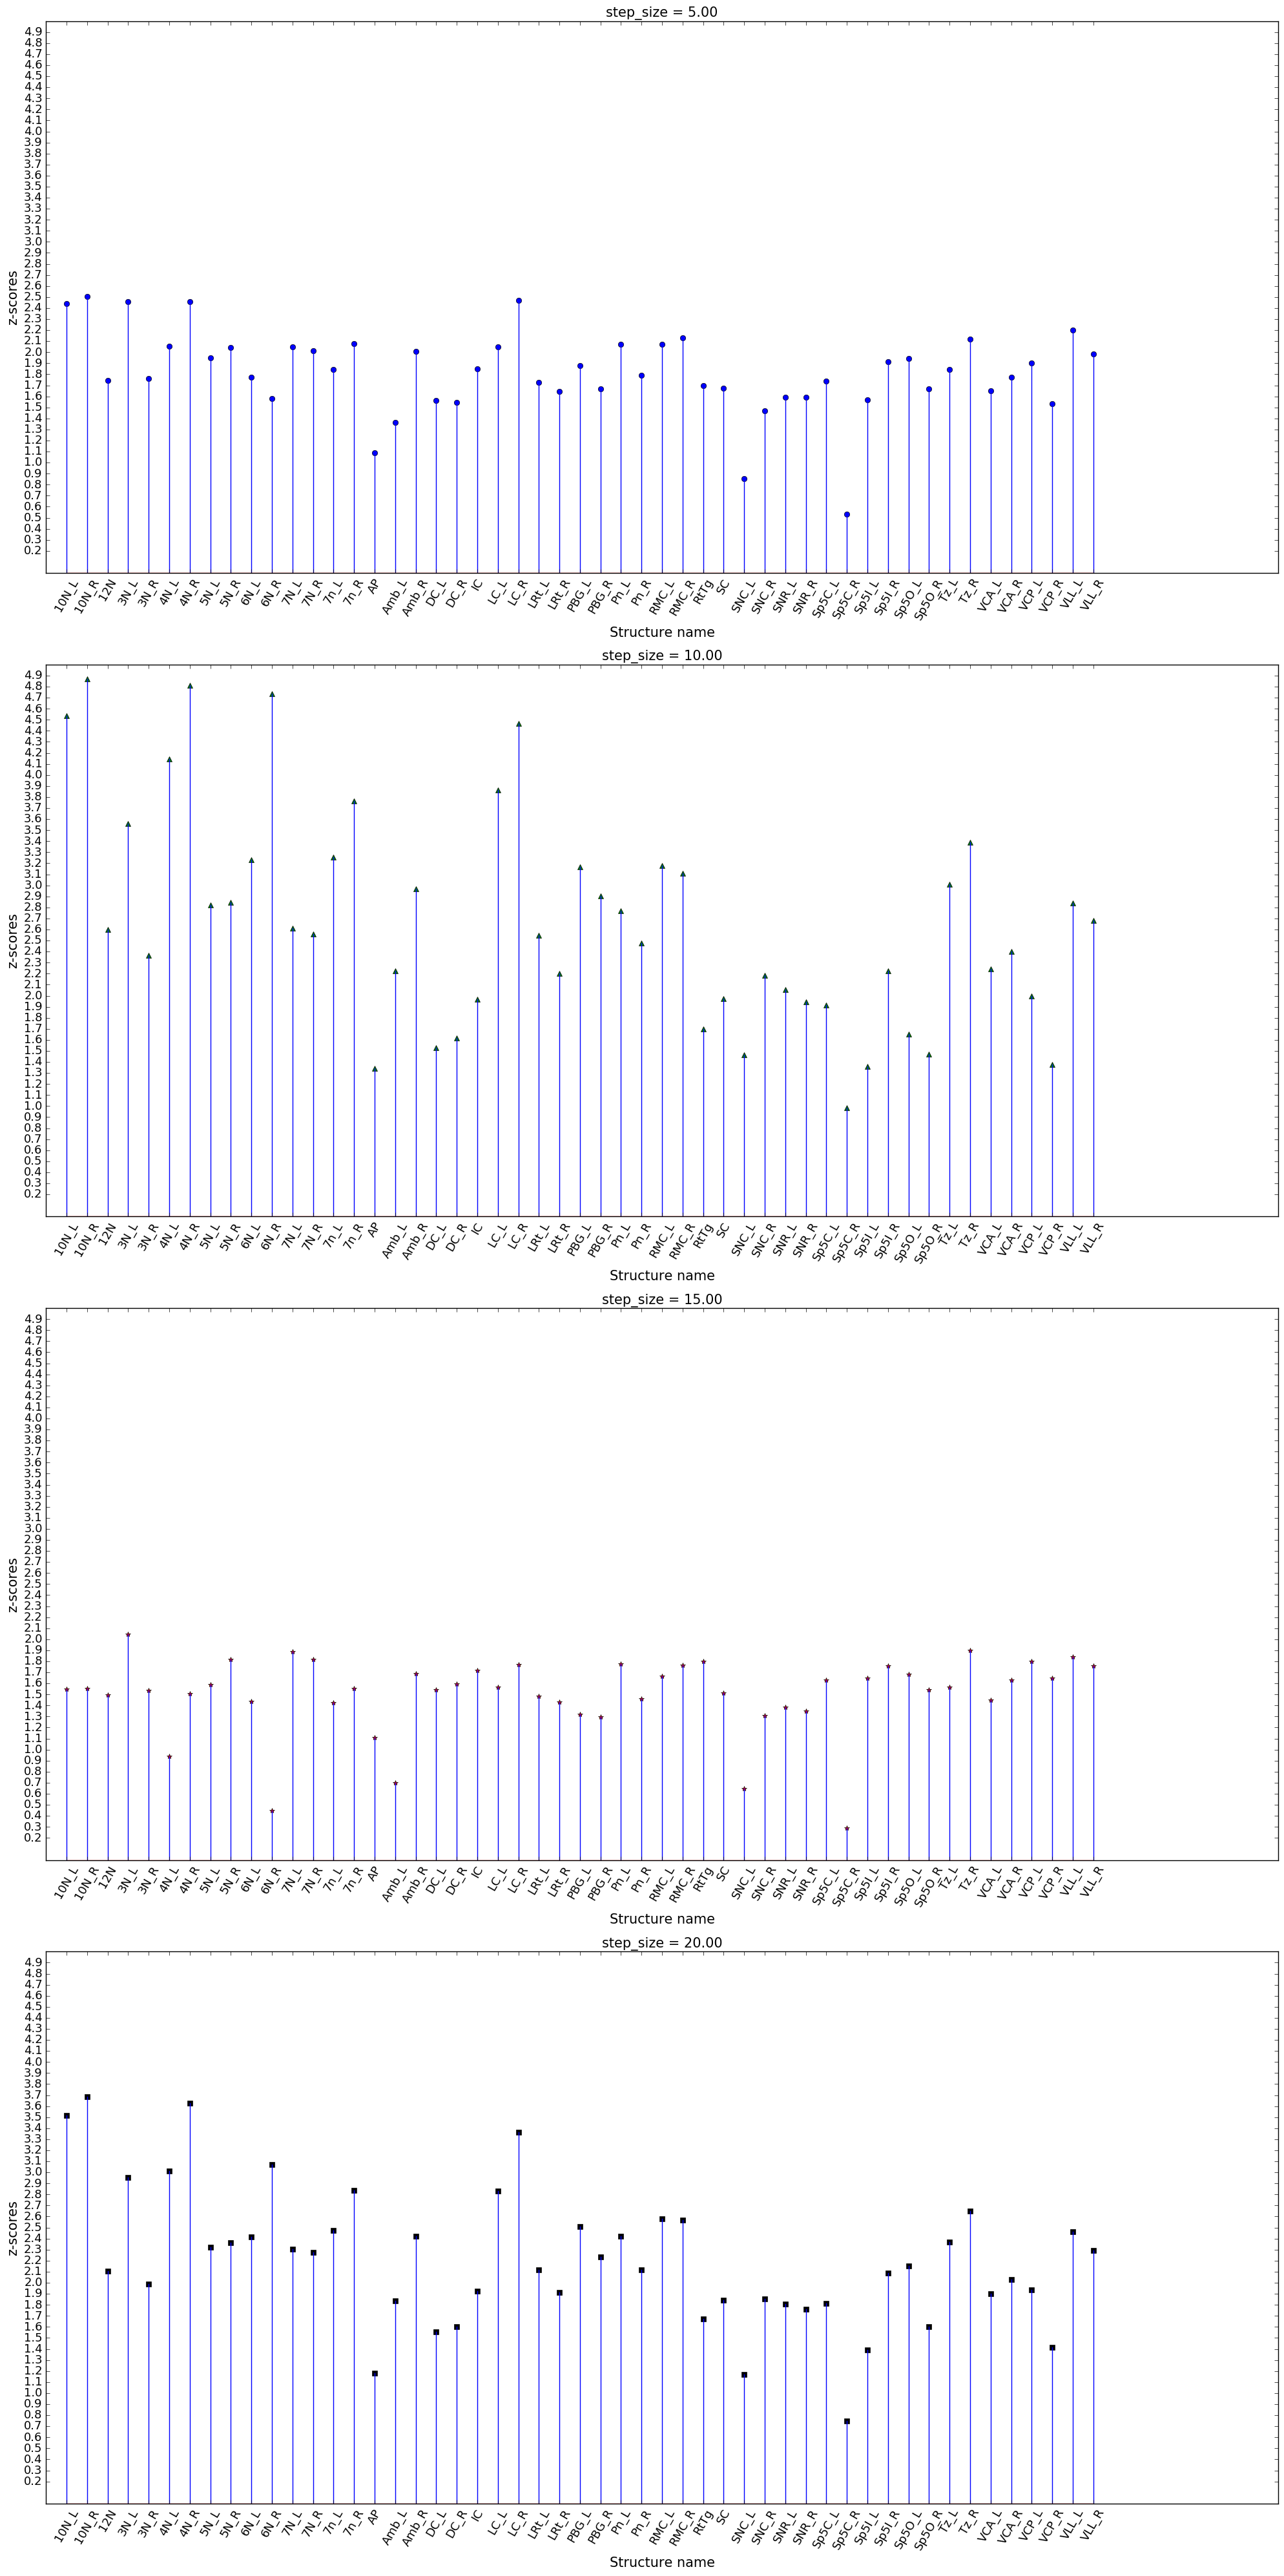

In [175]:
# fig = plt.figure(figsize=(20, 15));
fig, axes = plt.subplots(4, 1, figsize=(20, 40), sharex=False, sharey=True);

axes[0].stem(range(1, len(boxplot_labels)+1), D[:,0], markerfmt='bo', s=40);
axes[1].stem(range(1, len(boxplot_labels)+1), D[:,1], markerfmt='g^', s=40);
axes[2].stem(range(1, len(boxplot_labels)+1), D[:,2], markerfmt='r*', s=40);
axes[3].stem(range(1, len(boxplot_labels)+1), D[:,3], markerfmt='ks', s=40);

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, len(boxplot_labels)+1))
    ax.set_xticklabels(boxplot_labels, rotation='60', fontsize=13);
    ax.set_xlabel('Structure name', fontsize=15);
    ax.set_yticks(np.arange(0.2, 5, .1));
    ax.set_yticklabels(np.arange(0.2, 5, .1), fontsize=13);
    ax.set_ylabel('z-scores', fontsize=15);
    ax.set_title('step_size = %.2f' % pooling_radius_list[i], fontsize=15);

plt.tight_layout()

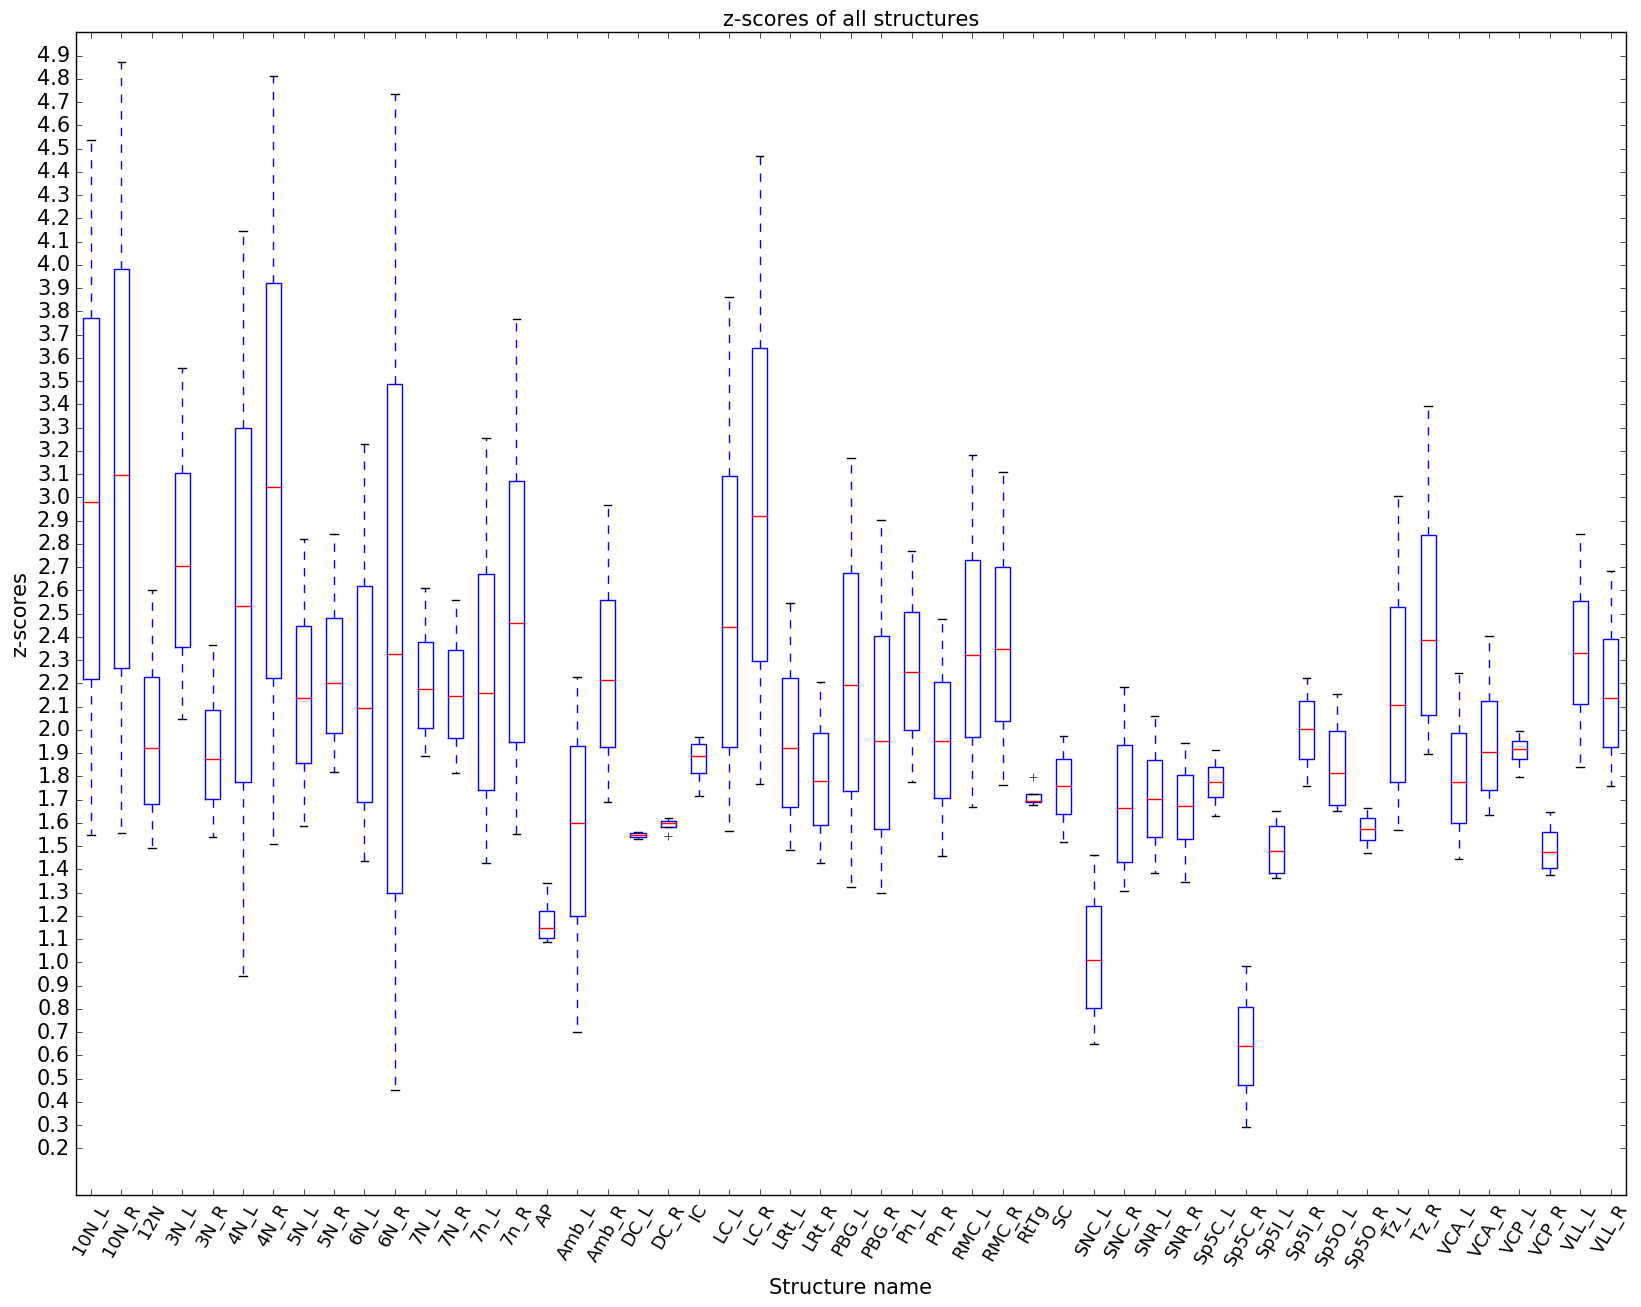

In [140]:
plt.figure(figsize=(20, 15));
plt.boxplot(D.T);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures', fontsize=15);

In [89]:
volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [127]:
dets_allStructures = {}

for name_s in structures_sided:

        
    fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(fp)
    
    dets = {step_size: np.abs(np.linalg.det(H / volume_moving_structure_sizes[name_to_label_moving[name_s]]))
            for step_size, H in hessians.iteritems()}
    
    dets_allStructures[name_s] = dets

In [134]:
H = [[z for r, z in d.items()][5:7] for n, d in sorted(dets_allStructures.items())]

In [130]:
boxplot_labels = sorted(dets_allStructures.keys())

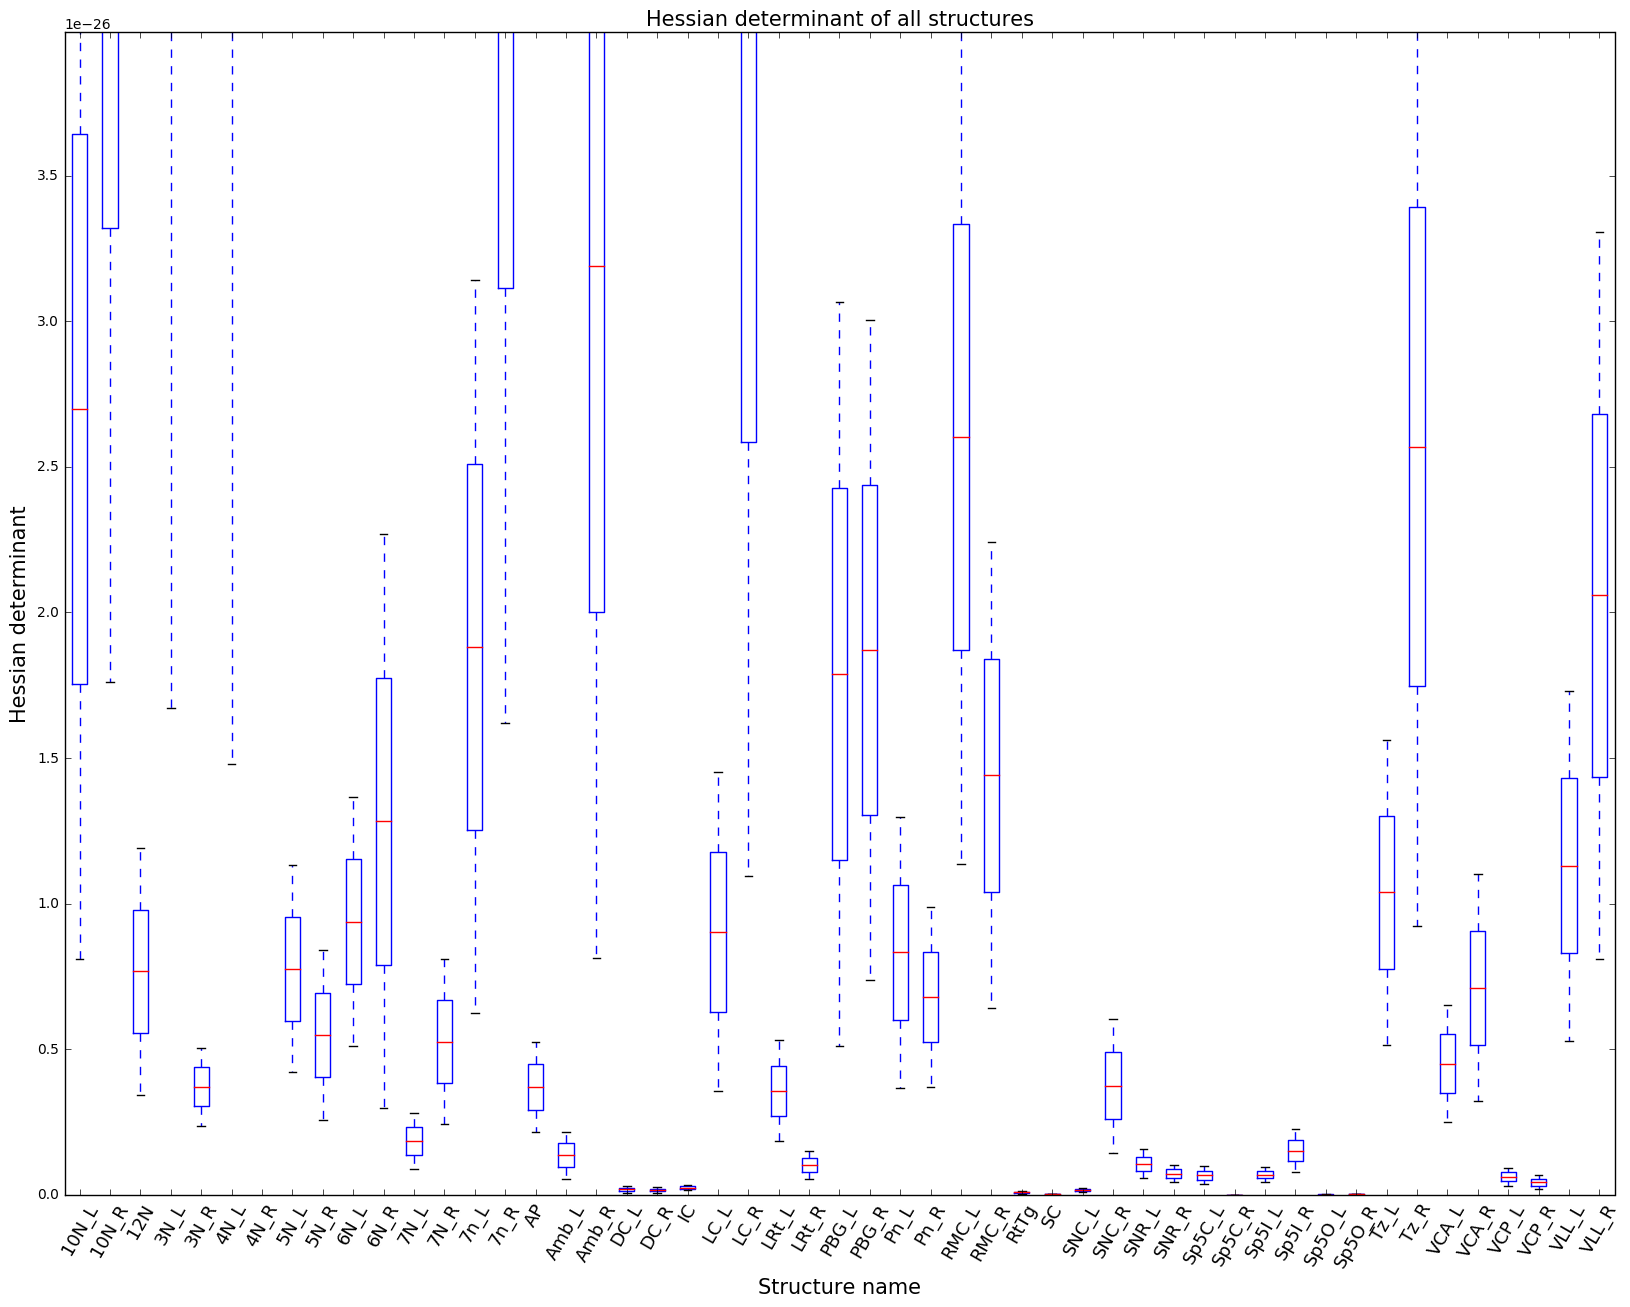

In [135]:
plt.figure(figsize=(20, 15));
plt.boxplot(H);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylim(0, np.percentile(H, 90));
plt.ylabel('Hessian determinant', fontsize=15);
plt.title('Hessian determinant of all structures', fontsize=15);

In [14]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['7N_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)
        
    ###########################################
    
#     def perturb(tx, ty, tz):
#         return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz])

# #     dets = []
#     Hs = []
#     step_sizes = np.linspace(1, 20, 11)

#     for step_size in step_sizes:
#         h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(step_size, step_size, step_size))
#         H = h((0,0,0))
#     #     s, v = np.linalg.eigh(H)
# #         d = np.abs(np.linalg.det(H))
# #         dets.append(d)
#         Hs.append(H)

#     plt.plot(dets);
#     plt.xlabel('step size (pixels)');
#     plt.xticks(range(len(step_sizes)), map(lambda x: '%.2f' % x, step_sizes));
#     plt.ylabel('determinant of Hessian matrix');
#     plt.title('Hessian for different step sizes');
#     plt.show();
    
#     dets_allStructures[name_s] = dets

    ############################################################
    
#     fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)

#     create_if_not_exists(os.path.dirname(fp))
#     save_pickle(dict(zip(step_sizes, Hs)), fp)
    
    ############################################################

    fmax = aligner.compute_score(tx_params)

#     zscores = []
#     pooling_radius_list = np.linspace(5, 20, 4)

#     for pooling_radius in pooling_radius_list:
        
    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)

#     zscores.append(z)

#     plt.plot(pooling_radius_list, zscores);
#     plt.xlabel('pooling radius (pixels)');
#     # plt.xticks(range(len(pooling_radius_list)), map(lambda x: '%.2f' % x, pooling_radius_list));
#     plt.ylabel('z-score');
#     plt.title('Z-score for different pooling radius');
#     plt.show();
    
#     zscores_allStructures[name_s] = zscores
    

In [15]:
fmax

0.038657989352941513

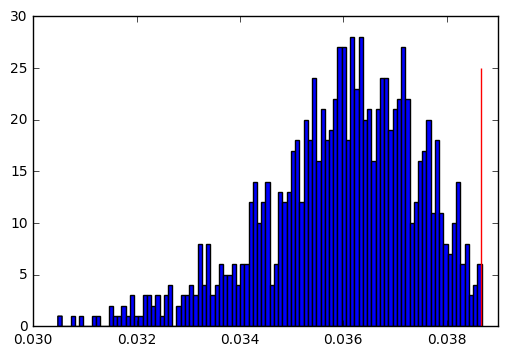

In [16]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');

In [147]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['VLL_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)

    ############################################################

    fmax = aligner.compute_score(tx_params)

    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)


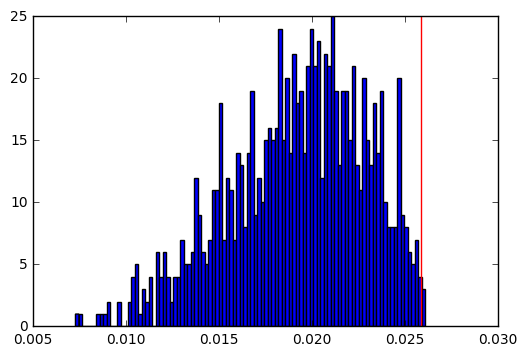

In [148]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');